In [1]:
"""N-hidden-layer Artifiial Neural Network for Nonclassical Adaptive Filtering"""

import numba.cuda
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm, tqdm_notebook

%matplotlib inline


In [2]:
# Load training data 1
t=np.linspace(0,1,100)
d_t=0.2+0.4*t**2+0.3*t*np.sin(15*t)+0.05*np.cos(50*t)
mapping_coeff=(d_t.max()-d_t.min())
nd_t=(d_t-d_t.min())/mapping_coeff
length=t.size

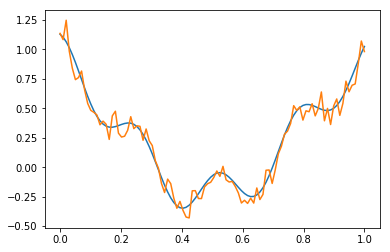

In [3]:
# Load training data 2
t=np.linspace(0,1,100); length=t.size
x_t=(np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +\
         0.1*np.sin(2*np.pi*1.25*t + 1) +\
         0.18*np.cos(2*np.pi*3.85*t))
f_t=x_t + np.random.randn(len(t)) * 0.08

plt.plot(t,x_t)
plt.plot(t,f_t)
plt.show()


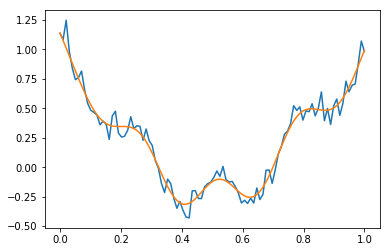

In [4]:
b, a = signal.butter(3, 0.1)
d_t = signal.filtfilt(b, a, f_t)

plt.plot(t,f_t)
plt.plot(t,d_t)
plt.show()

#plt.plot(x_t-d_t) plt.show()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10827.45it/s]


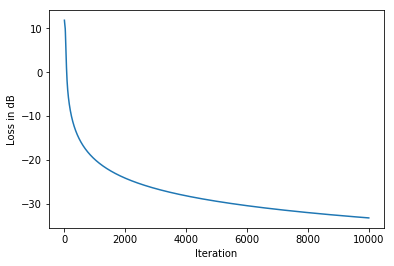

In [12]:
mapping_bias=d_t.min()
mapping_coeff=(d_t.max()-mapping_bias)
d_t2=(d_t-mapping_bias)/mapping_coeff

# model specifications
Ni=100; Nh1=2; Nh2=2; No=100;
#parameter and array initialization
alpha,hidden_dim,dropout_percent,do_dropout = (0.5,1,0.2,True)
epochs=10000
wh1=np.random.randn(Nh1,Ni); dwh1=np.zeros(wh1.shape) 
wh2=np.random.randn(Nh2,Nh1); dwh2=np.zeros(wh2.shape) 
wo=np.random.randn(No,Nh2); dwo=np.zeros(wo.shape) 
op=np.array([])
error=np.array([])

#@vectorize
for epoch in tqdm(range(epochs)):
    #for batch in range(np.int_(length/Ni)):        
        X=f_t#[batch*Ni:(batch+1)*Ni]
        Y=d_t2#[batch*Ni:(batch+1)*Ni]
        #if(~do_dropout):
        #    X *= np.random.binomial([np.ones((len(X),hidden_dim))],1-\
         #                                 dropout_percent)[0,0] * (1.0/(1-dropout_percent))
        h1=1/(1+np.exp(-wh1@X))
        #if(~do_dropout):
        #    h1 *= np.random.binomial([np.ones((len(h1),hidden_dim))],1-\
          #                                dropout_percent)[0,0] * (1.0/(1-dropout_percent))
        h2=1/(1+np.exp(-wh2@h1))
        #if(~do_dropout):
        #    h2 *= np.random.binomial([np.ones((len(h2),hidden_dim))],1-\
           #                               dropout_percent)[0,0] * (1.0/(1-dropout_percent))
        yout=-wo@h2
        y=1/(1+np.exp(yout)) #output for all pattern
        #op=np.append(op,y)

        do=y*(1-y)*(Y-y)  # delta output
        dh2=h2*(1-h2)*(wo.transpose()@do)  # delta backpropagated
        dh1=h1*(1-h1)*(wh2.transpose()@dh2)
            
        # update weights with momentum
        dwh1=0.9*np.outer(dh1,X) # 0.9*
        wh1=wh1+0.1*dwh1
        
        dwh2=0.9*np.outer(dh2,h1)
        wh2=wh2+0.1*dwh2
        
        dwo=0.9*dwo+np.outer(do,h2) # 0.9*dwo+
        wo=wo+0.1*dwo
        
        loss=10*np.log10(np.sum((Y-y)**2))
        error=np.append(error,loss)

y*=mapping_coeff
y+=mapping_bias
plt.xlabel("Iteration")
plt.ylabel("Loss in dB")
plt.plot(error)
plt.show()

In [6]:
mapping_bias=d_t.min()
mapping_coeff=(d_t.max()-mapping_bias)
d_t2=(d_t-mapping_bias)/mapping_coeff

# model specifications
Ni=100; Nh1=1024; Nh2=1024; No=100;
#parameter and array initialization
epochs=100000
wh=np.random.randn(Nh,Ni); dwh=np.zeros(wh.shape) 
wo=np.random.randn(No,Nh); dwo=np.zeros(wo.shape) 
op=np.array([])
error=np.array([])

for epoch in tqdm_notebook(range(epochs)):
    #for batch in range(np.int_(length/Ni)):        
        X=f_t#[batch*Ni:(batch+1)*Ni]
        Y=d_t2#[batch*Ni:(batch+1)*Ni]
        h=1/(1+np.exp(-wh@X)) #hidden activation for all pattern
        yout=-wo@h
        y=1/(1+np.exp(yout)) #output for all pattern
        #op=np.append(op,y)

        do=y*(1-y)*(Y-y)  # delta output
        dh=h*(1-h)*(wo.transpose()@do)  # delta backpropagated  
            
        # update weights with momentum
        dwh=0.9*np.outer(dh,X) # 0.9*
        wh=wh+0.1*dwh
        dwo=0.9*dwo+np.outer(do,h) # 0.9*dwo+
        wo=wo+0.1*dwo
        
        loss=10*np.log10(np.sum((Y-y)**2))
        error=np.append(error,loss)

y*=mapping_coeff
y+=mapping_bias
plt.xlabel("Iteration")
plt.ylabel("Loss in dB")
plt.plot(error)
plt.show()

NameError: name 'Nh' is not defined

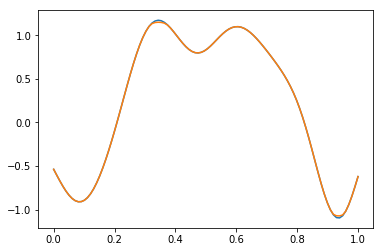

In [13]:
plt.plot(t,d_t)
plt.plot(t,y)
plt.show()

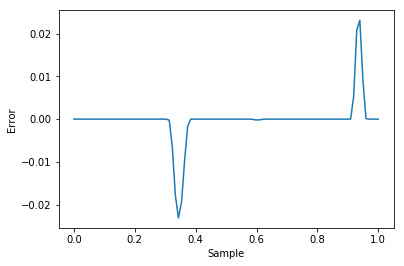

In [14]:
plt.plot(t,y-d_t)
plt.xlabel('Sample')
plt.ylabel('Error')
plt.show()

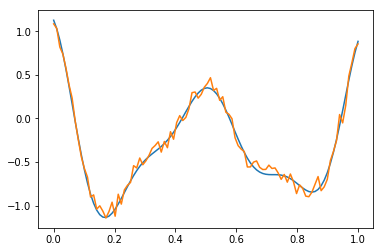

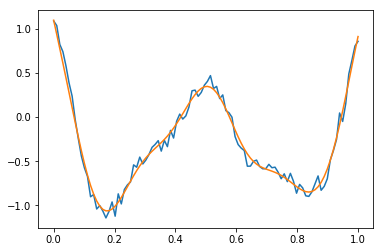

In [20]:
# Load eval data
t=np.linspace(0,1,100); length=t.size
x_t=(np.sin(2*np.pi*2.75*t*(1-t) + 2.1) +\
         0.1*np.sin(2*np.pi*2.5*t + 1) +\
         0.18*np.cos(2*np.pi*3.85*t))
f_t=x_t + np.random.randn(len(t)) * 0.08

plt.plot(t,x_t)
plt.plot(t,f_t)
plt.show()

b, a = signal.butter(3, 0.1)
d_t = signal.filtfilt(b, a, f_t)

plt.plot(t,f_t)
plt.plot(t,d_t)
plt.show()

#plt.plot(x_t-d_t); plt.show()

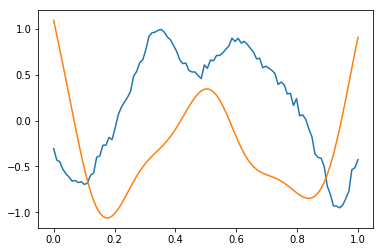

In [22]:
mapping_bias=d_t.min()
mapping_coeff=(d_t.max()-mapping_bias)
d_t2=(d_t-mapping_bias)/mapping_coeff

X=f_t
Y=d_t2
h1=1/(1+np.exp(-wh1@X))
h2=1/(1+np.exp(-wh2@h1))
yout=-wo@h2
y=1/(1+np.exp(yout)) 
        
y*=mapping_coeff
y+=mapping_bias

plt.plot(t,y)
plt.plot(t,d_t)
#plt.plot(t,f_t)
plt.show()

In [ ]:

for epoch in tqdm_notebook(range(epochs)):
    #for batch in range(np.int_(length/Ni)):        
        X=f_t#[batch*Ni:(batch+1)*Ni]
        Y=d_t2#[batch*Ni:(batch+1)*Ni]
        h=1/(1+np.exp(-wh@X)) #hidden activation for all pattern
        yout=-wo@h
        y=1/(1+np.exp(yout)) #output for all pattern
        #op=np.append(op,y)

        do=y*(1-y)*(Y-y)  # delta output
        dh=h*(1-h)*(wo.transpose()@do)  # delta backpropagated  
            
        # update weights with momentum
        dwh=0.9*np.outer(dh,X) # 0.9*
        wh=wh+0.1*dwh
        dwo=0.9*dwo+np.outer(do,h) # 0.9*dwo+
        wo=wo+0.1*dwo
        
        loss=10*np.log10(np.sum((Y-y)**2))
        error=np.append(error,loss)


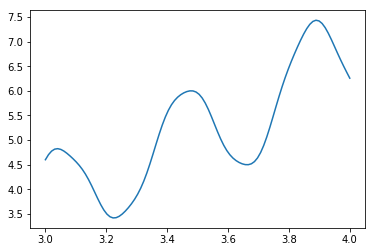

In [218]:
t=np.linspace(3,4,100)
d_t=0.2+0.4*t**2+0.3*t*np.sin(15*t)+0.05*np.cos(50*t)

plt.plot(t,d_t)
plt.show()


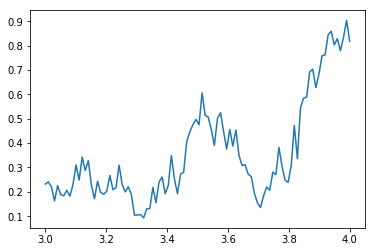

In [219]:
X=t
Y=d_t
h=1/(1+np.exp(-wh@X)) #hidden activation for all pattern
yout=-wo@h
y=1/(1+np.exp(yout))
        
plt.plot(t,y)
plt.show()

In [ ]:
############### multiply with coeff

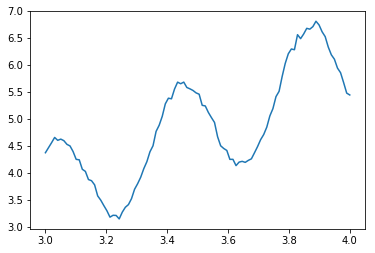

In [220]:
plt.plot(t,d_t-y)
plt.show()

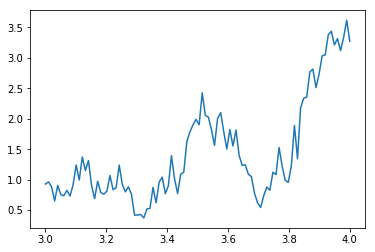

In [221]:
plt.plot(t,4*y)
plt.show()

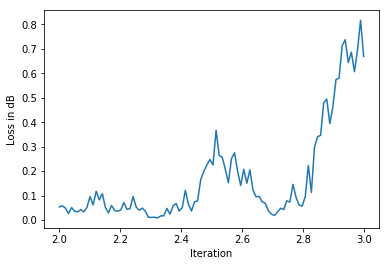

In [212]:
loss=(np.abs((d_t-(d_t-y))**2))

plt.xlabel("Iteration")
plt.ylabel("Loss in dB")
plt.plot(t,loss)
plt.show()

In [154]:
def normalize(func):
    mapping_coeff=(func.max()-func.min())
    nfunc=(func-func.min())/mapping_coeff
    return nfunc, mapping_coeff